# Polyethylene Stress Relaxation

Fit HDPE relaxation modulus with GM and fractional models.

**Data:** examples/data/relaxation/polymers/stressrelaxation_hdpe_data.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rheojax.models import FractionalMaxwellModel
from rheojax.models import GeneralizedMaxwell

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)

def load_tab_file(path):
    df = pd.read_csv(path, sep='	')
    df.columns = df.columns.str.strip()
    df = df.dropna()
    df.iloc[:,0] = pd.to_numeric(df.iloc[:,0], errors='coerce')
    df.iloc[:,1] = pd.to_numeric(df.iloc[:,1], errors='coerce')
    df = df.dropna()
    return df
import arviz as az


## Load relaxation data

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'relaxation' / 'polymers'
df = load_tab_file(DATA_DIR / 'stressrelaxation_hdpe_data.csv')
t = df.iloc[:,0].to_numpy()
G = df.iloc[:,1].to_numpy()


## Fit relaxation models

In [4]:
gm = GeneralizedMaxwell(n_modes=6, modulus_type='tensile')
gm.fit(t, G, test_mode='relaxation', use_log_residuals=True, use_multi_start=True)
gm_pred = gm.predict(t)
gm_r2 = gm.score(t, G)

fm = FractionalMaxwellModel()
fm.fit(t, G, test_mode='relaxation', use_log_residuals=True)
fm_pred = fm.predict(t, test_mode='relaxation')
fm_r2 = r2_complex(G, fm_pred)

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.183421s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=28 | final_cost=2.5523e+12 | elapsed=1.183s | final_gradient_norm=4.0067e+15


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.437050s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=28 | final_cost=2.5523e+12 | elapsed=0.437s | final_gradient_norm=4.0067e+15


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.962264s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=8.4482e+12 | elapsed=0.962s | final_gradient_norm=7.5405e+15


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


[WARNING] Inner optimization loop hit iteration limit inner_iterations=100 | actual_reduction=-1


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.590654s


INFO:nlsq.least_squares:Convergence reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=704.3415 | elapsed=1.591s | final_gradient_norm=nan


ERROR:rheojax.utils.optimization:Failed to compute covariance from Jacobian
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 87, in compute_covariance_from_jacobian
    U, s, VT = np.linalg.svd(jac, full_matrices=False)
               ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 1862, in svd
    u, s, vh = gufunc(a, signature=signature)
               ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 172, in _raise_linalgerror_svd_nonconvergence
    raise LinAlgError("SVD did not converge")
numpy.linalg.LinAlgError: SVD did not converge


{'gm_r2': 0.9999910890040699, 'fm_r2': -354.19457717563756}


## Plot relaxation fits

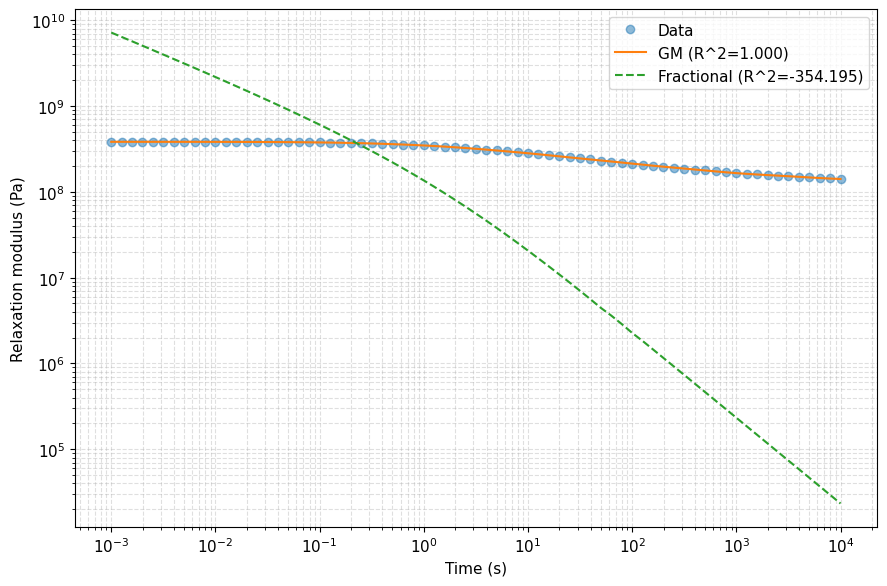

In [5]:
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(t, G, 'o', label='Data', alpha=0.5)
ax.loglog(t, gm_pred, '-', label=f'GM (R^2={gm_r2:.3f})')
ax.loglog(t, fm_pred, '--', label=f'Fractional (R^2={fm_r2:.3f})')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Relaxation modulus (Pa)')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

In [6]:
# Helper functions for workflow
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        """Compute R² for complex-valued data."""
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot

if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        """Convert 2-column real array to complex if needed."""
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr

NUTS_CONFIG = dict(num_chains=1, num_warmup=200, num_samples=500)  # Fast demo mode


In [7]:
def _detect_datasets():
    """Auto-detect datasets from global variables."""
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': G_star, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': Gp + 1j * Gpp, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        test_mode = master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation'
        datasets.append({
            'X': master.x, 'y': master.y, 'test_mode': test_mode,
            'x_label': 'Shifted frequency', 'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({'X': t, 'y': G, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'E_t' in globals():
        datasets.append({'X': t, 'y': E_t, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'sigma' in globals():
        datasets.append({'X': t, 'y': sigma, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Stress (Pa)'})
    if 't' in globals() and 'J' in globals():
        datasets.append({'X': t, 'y': J, 'test_mode': 'creep', 'x_label': 'Time (s)', 'y_label': 'Creep compliance'})
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals, 'y': y_vals, 'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})', 'y_label': 'Stress (Pa)', 'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined.')
    return datasets

def _collect_candidate_models():
    """Collect candidate models from global variables."""
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running.')
    return models

datasets = _detect_datasets()
model_entries = _collect_candidate_models()
print(f"Found {len(datasets)} dataset(s) and {len(model_entries)} model(s)")


Found 1 dataset(s) and 2 model(s)


In [8]:
# NLSQ fitting loop - fit all models to all datasets
all_fits = {}  # {dataset_idx: [fit_records]}

for ds_idx, ds in enumerate(datasets):
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            try:
                fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
            except Exception as exc:
                print(f"Skipping {name} due to fit error: {exc}")
                continue
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue

        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue

        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue

        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    all_fits[ds_idx] = fits
    if fits:
        print(f"Dataset {ds_idx} ranking: {[(r['name'], round(r['r2'], 3)) for r in fits]}")
    else:
        print(f"Dataset {ds_idx}: No successful fits")


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.482192s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=28 | final_cost=2.5523e+12 | elapsed=0.482s | final_gradient_norm=4.0067e+15


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.524690s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=28 | final_cost=2.5523e+12 | elapsed=0.525s | final_gradient_norm=4.0067e+15


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.610841s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=8.4482e+12 | elapsed=0.611s | final_gradient_norm=7.5405e+15


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
TypeError: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Skipping gm due to predict error: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


[WARNING] Inner optimization loop hit iteration limit inner_iterations=100 | actual_reduction=-1


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.710172s


INFO:nlsq.least_squares:Convergence reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=704.3415 | elapsed=0.710s | final_gradient_norm=nan


ERROR:rheojax.utils.optimization:Failed to compute covariance from Jacobian
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 87, in compute_covariance_from_jacobian
    U, s, VT = np.linalg.svd(jac, full_matrices=False)
               ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 1862, in svd
    u, s, vh = gufunc(a, signature=signature)
               ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 172, in _raise_linalgerror_svd_nonconvergence
    raise LinAlgError("SVD did not converge")
numpy.linalg.LinAlgError: SVD did not converge


Dataset 0 ranking: [('fm', -354.195)]


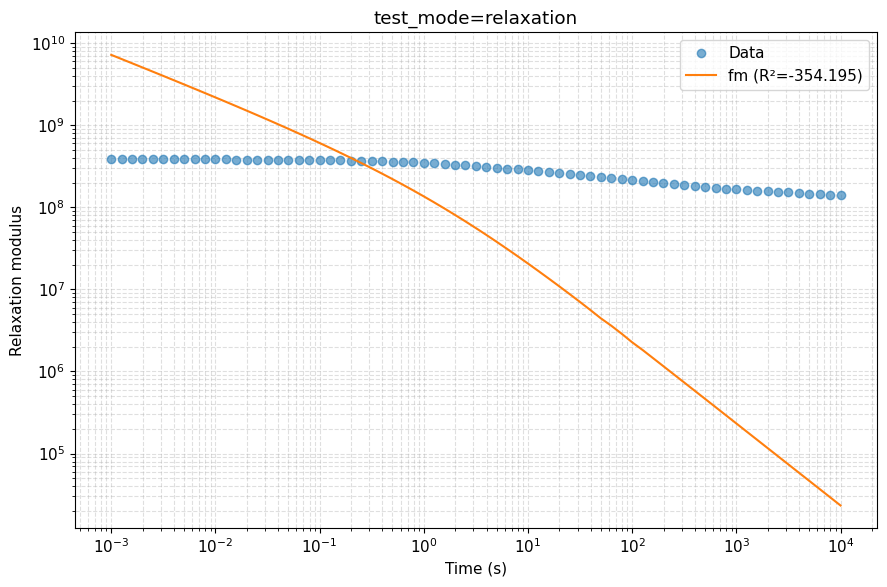

  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<04:52,  2.39it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   2%|▏         | 16/700 [00:00<00:17, 39.81it/s, 1 steps of size 2.78e-06. acc. prob=0.68]

warmup:   4%|▎         | 26/700 [00:00<00:12, 55.40it/s, 7 steps of size 8.49e-07. acc. prob=0.77]

warmup:   5%|▌         | 36/700 [00:00<00:12, 52.17it/s, 6 steps of size 3.04e-07. acc. prob=0.81]

warmup:   6%|▋         | 44/700 [00:01<00:14, 44.50it/s, 9 steps of size 1.97e-07. acc. prob=0.83]

warmup:   7%|▋         | 51/700 [00:01<00:14, 43.85it/s, 5 steps of size 7.09e-08. acc. prob=0.83]

warmup:   8%|▊         | 57/700 [00:01<00:15, 40.69it/s, 17 steps of size 2.76e-08. acc. prob=0.84]

warmup:   9%|▉         | 62/700 [00:01<00:21, 29.40it/s, 10 steps of size 3.42e-08. acc. prob=0.85]

warmup:   9%|▉         | 66/700 [00:01<00:25, 25.07it/s, 55 steps of size 4.07e-08. acc. prob=0.85]

warmup:  10%|█         | 70/700 [00:02<00:31, 20.12it/s, 34 steps of size 5.28e-08. acc. prob=0.86]

warmup:  10%|█         | 73/700 [00:02<00:32, 19.17it/s, 27 steps of size 6.17e-08. acc. prob=0.86]

warmup:  11%|█         | 77/700 [00:02<00:29, 21.16it/s, 31 steps of size 5.87e-08. acc. prob=0.87]

warmup:  12%|█▏        | 81/700 [00:02<00:27, 22.50it/s, 65 steps of size 3.58e-09. acc. prob=0.85]

warmup:  12%|█▏        | 84/700 [00:04<01:28,  6.98it/s, 100 steps of size 4.94e-09. acc. prob=0.86]

warmup:  12%|█▏        | 86/700 [00:05<02:24,  4.26it/s, 189 steps of size 6.17e-09. acc. prob=0.86]

warmup:  13%|█▎        | 88/700 [00:06<03:16,  3.11it/s, 390 steps of size 7.69e-09. acc. prob=0.87]

warmup:  13%|█▎        | 89/700 [00:07<03:30,  2.90it/s, 266 steps of size 8.54e-09. acc. prob=0.87]

warmup:  13%|█▎        | 90/700 [00:07<03:40,  2.77it/s, 255 steps of size 9.56e-09. acc. prob=0.87]

warmup:  13%|█▎        | 91/700 [00:08<03:55,  2.59it/s, 273 steps of size 1.06e-08. acc. prob=0.87]

warmup:  13%|█▎        | 92/700 [00:08<03:39,  2.76it/s, 153 steps of size 1.17e-08. acc. prob=0.87]

warmup:  13%|█▎        | 93/700 [00:08<03:15,  3.10it/s, 102 steps of size 1.28e-08. acc. prob=0.87]

warmup:  13%|█▎        | 94/700 [00:08<03:01,  3.33it/s, 132 steps of size 1.40e-08. acc. prob=0.87]

warmup:  14%|█▎        | 95/700 [00:09<02:35,  3.90it/s, 76 steps of size 1.52e-08. acc. prob=0.87] 

warmup:  14%|█▎        | 96/700 [00:09<02:49,  3.57it/s, 186 steps of size 1.67e-08. acc. prob=0.88]

warmup:  14%|█▍        | 97/700 [00:09<02:58,  3.38it/s, 152 steps of size 1.83e-08. acc. prob=0.88]

warmup:  14%|█▍        | 98/700 [00:09<02:26,  4.11it/s, 62 steps of size 1.97e-08. acc. prob=0.88] 

warmup:  14%|█▍        | 100/700 [00:10<01:47,  5.58it/s, 86 steps of size 2.18e-08. acc. prob=0.88]

warmup:  14%|█▍        | 101/700 [00:12<06:03,  1.65it/s, 1023 steps of size 2.22e-07. acc. prob=0.88]

warmup:  15%|█▍        | 102/700 [00:12<05:12,  1.91it/s, 148 steps of size 2.25e-07. acc. prob=0.88] 

warmup:  15%|█▍        | 103/700 [00:12<04:16,  2.32it/s, 86 steps of size 2.25e-07. acc. prob=0.88] 

warmup:  15%|█▌        | 105/700 [00:12<02:55,  3.38it/s, 94 steps of size 2.15e-07. acc. prob=0.89]

warmup:  15%|█▌        | 106/700 [00:13<04:30,  2.19it/s, 548 steps of size 2.20e-07. acc. prob=0.89]

warmup:  15%|█▌        | 107/700 [00:13<04:04,  2.43it/s, 151 steps of size 2.23e-07. acc. prob=0.89]

warmup:  15%|█▌        | 108/700 [00:14<03:29,  2.83it/s, 102 steps of size 2.23e-07. acc. prob=0.89]

warmup:  16%|█▌        | 109/700 [00:14<03:51,  2.55it/s, 273 steps of size 2.27e-07. acc. prob=0.89]

warmup:  16%|█▌        | 111/700 [00:14<02:28,  3.97it/s, 66 steps of size 1.84e-07. acc. prob=0.89] 

warmup:  16%|█▌        | 112/700 [00:15<04:02,  2.43it/s, 519 steps of size 1.89e-07. acc. prob=0.89]

warmup:  16%|█▌        | 113/700 [00:16<05:24,  1.81it/s, 520 steps of size 1.94e-07. acc. prob=0.89]

warmup:  16%|█▋        | 114/700 [00:16<04:14,  2.31it/s, 56 steps of size 1.89e-07. acc. prob=0.89] 

warmup:  16%|█▋        | 115/700 [00:17<04:51,  2.01it/s, 368 steps of size 1.94e-07. acc. prob=0.89]

warmup:  17%|█▋        | 116/700 [00:17<04:03,  2.40it/s, 119 steps of size 1.95e-07. acc. prob=0.90]

warmup:  17%|█▋        | 117/700 [00:17<03:36,  2.69it/s, 148 steps of size 1.97e-07. acc. prob=0.90]

warmup:  17%|█▋        | 119/700 [00:18<02:15,  4.30it/s, 51 steps of size 1.72e-07. acc. prob=0.90] 

warmup:  17%|█▋        | 121/700 [00:18<01:38,  5.89it/s, 39 steps of size 1.57e-07. acc. prob=0.90]

warmup:  17%|█▋        | 122/700 [00:18<01:57,  4.94it/s, 169 steps of size 1.59e-07. acc. prob=0.90]

warmup:  18%|█▊        | 123/700 [00:19<02:57,  3.25it/s, 320 steps of size 1.63e-07. acc. prob=0.90]

warmup:  18%|█▊        | 124/700 [00:19<03:08,  3.06it/s, 211 steps of size 1.65e-07. acc. prob=0.90]

warmup:  18%|█▊        | 125/700 [00:19<02:50,  3.38it/s, 119 steps of size 1.67e-07. acc. prob=0.90]

warmup:  18%|█▊        | 127/700 [00:20<03:54,  2.44it/s, 569 steps of size 1.64e-07. acc. prob=0.90]

warmup:  18%|█▊        | 128/700 [00:21<04:02,  2.36it/s, 261 steps of size 1.67e-07. acc. prob=0.90]

warmup:  18%|█▊        | 129/700 [00:21<03:36,  2.64it/s, 137 steps of size 1.69e-07. acc. prob=0.90]

warmup:  19%|█▊        | 130/700 [00:22<03:53,  2.44it/s, 284 steps of size 1.72e-07. acc. prob=0.90]

warmup:  19%|█▊        | 131/700 [00:23<05:27,  1.74it/s, 557 steps of size 1.77e-07. acc. prob=0.91]

warmup:  19%|█▉        | 132/700 [00:24<07:26,  1.27it/s, 738 steps of size 1.81e-07. acc. prob=0.91]

warmup:  19%|█▉        | 133/700 [00:24<06:37,  1.43it/s, 281 steps of size 1.84e-07. acc. prob=0.91]

warmup:  19%|█▉        | 134/700 [00:25<07:00,  1.34it/s, 467 steps of size 1.89e-07. acc. prob=0.91]

warmup:  19%|█▉        | 135/700 [00:27<09:53,  1.05s/it, 933 steps of size 1.93e-07. acc. prob=0.91]

warmup:  19%|█▉        | 136/700 [00:28<08:35,  1.09it/s, 307 steps of size 1.97e-07. acc. prob=0.91]

warmup:  20%|█▉        | 137/700 [00:29<09:04,  1.03it/s, 616 steps of size 2.01e-07. acc. prob=0.91]

warmup:  20%|█▉        | 138/700 [00:29<07:48,  1.20it/s, 280 steps of size 2.05e-07. acc. prob=0.91]

warmup:  20%|█▉        | 139/700 [00:29<05:53,  1.59it/s, 87 steps of size 2.04e-07. acc. prob=0.91] 

warmup:  20%|██        | 140/700 [00:30<04:43,  1.97it/s, 126 steps of size 2.05e-07. acc. prob=0.91]

warmup:  20%|██        | 141/700 [00:30<05:36,  1.66it/s, 457 steps of size 2.09e-07. acc. prob=0.91]

warmup:  20%|██        | 142/700 [00:31<06:26,  1.44it/s, 517 steps of size 2.14e-07. acc. prob=0.91]

warmup:  20%|██        | 143/700 [00:32<05:34,  1.67it/s, 221 steps of size 2.16e-07. acc. prob=0.91]

warmup:  21%|██        | 144/700 [00:32<04:19,  2.14it/s, 93 steps of size 2.16e-07. acc. prob=0.91] 

warmup:  21%|██        | 145/700 [00:32<04:34,  2.02it/s, 310 steps of size 2.20e-07. acc. prob=0.91]

warmup:  21%|██        | 146/700 [00:33<04:12,  2.20it/s, 196 steps of size 2.22e-07. acc. prob=0.91]

warmup:  21%|██        | 148/700 [00:33<02:51,  3.21it/s, 138 steps of size 2.08e-07. acc. prob=0.92]

warmup:  21%|██▏       | 149/700 [00:34<03:03,  3.00it/s, 232 steps of size 2.11e-07. acc. prob=0.92]

warmup:  21%|██▏       | 150/700 [00:34<03:51,  2.38it/s, 380 steps of size 2.14e-07. acc. prob=0.92]

warmup:  22%|██▏       | 151/700 [00:35<05:29,  1.67it/s, 602 steps of size 2.18e-06. acc. prob=0.92]

warmup:  22%|██▏       | 152/700 [00:35<04:34,  1.99it/s, 144 steps of size 2.20e-06. acc. prob=0.92]

warmup:  22%|██▏       | 153/700 [00:36<04:01,  2.26it/s, 161 steps of size 2.23e-06. acc. prob=0.92]

warmup:  22%|██▏       | 154/700 [00:36<03:28,  2.62it/s, 137 steps of size 2.26e-06. acc. prob=0.92]

warmup:  22%|██▏       | 155/700 [00:36<02:51,  3.17it/s, 76 steps of size 2.24e-06. acc. prob=0.92] 

warmup:  22%|██▏       | 156/700 [00:36<02:33,  3.55it/s, 116 steps of size 2.25e-06. acc. prob=0.92]

warmup:  22%|██▏       | 157/700 [00:37<02:46,  3.27it/s, 207 steps of size 2.29e-06. acc. prob=0.92]

warmup:  23%|██▎       | 158/700 [00:37<02:25,  3.73it/s, 98 steps of size 2.29e-06. acc. prob=0.92] 

warmup:  23%|██▎       | 160/700 [00:37<01:56,  4.62it/s, 121 steps of size 2.24e-06. acc. prob=0.92]

warmup:  23%|██▎       | 161/700 [00:37<01:44,  5.18it/s, 65 steps of size 2.20e-06. acc. prob=0.92] 

warmup:  23%|██▎       | 163/700 [00:38<01:32,  5.81it/s, 118 steps of size 2.12e-06. acc. prob=0.92]

warmup:  23%|██▎       | 164/700 [00:38<01:25,  6.24it/s, 67 steps of size 2.09e-06. acc. prob=0.92] 

warmup:  24%|██▎       | 165/700 [00:38<01:56,  4.59it/s, 213 steps of size 2.13e-06. acc. prob=0.92]

warmup:  24%|██▎       | 166/700 [00:38<02:12,  4.02it/s, 174 steps of size 2.15e-06. acc. prob=0.92]

warmup:  24%|██▍       | 167/700 [00:39<01:59,  4.48it/s, 88 steps of size 2.14e-06. acc. prob=0.92] 

warmup:  24%|██▍       | 169/700 [00:39<01:37,  5.43it/s, 95 steps of size 2.07e-06. acc. prob=0.92]

warmup:  24%|██▍       | 170/700 [00:39<01:27,  6.03it/s, 61 steps of size 2.03e-06. acc. prob=0.93]

warmup:  24%|██▍       | 171/700 [00:39<01:29,  5.91it/s, 102 steps of size 2.03e-06. acc. prob=0.93]

warmup:  25%|██▍       | 172/700 [00:39<01:21,  6.48it/s, 60 steps of size 1.99e-06. acc. prob=0.93] 

warmup:  25%|██▍       | 173/700 [00:39<01:25,  6.15it/s, 98 steps of size 1.99e-06. acc. prob=0.93]

warmup:  25%|██▍       | 174/700 [00:40<01:16,  6.86it/s, 58 steps of size 1.95e-06. acc. prob=0.93]

warmup:  25%|██▌       | 175/700 [00:40<01:24,  6.23it/s, 104 steps of size 1.96e-06. acc. prob=0.93]

warmup:  25%|██▌       | 176/700 [00:40<01:34,  5.56it/s, 120 steps of size 1.97e-06. acc. prob=0.93]

warmup:  25%|██▌       | 177/700 [00:40<01:31,  5.73it/s, 81 steps of size 1.95e-06. acc. prob=0.93] 

warmup:  25%|██▌       | 178/700 [00:40<01:35,  5.48it/s, 100 steps of size 1.96e-06. acc. prob=0.93]

warmup:  26%|██▌       | 180/700 [00:41<01:20,  6.47it/s, 96 steps of size 1.88e-06. acc. prob=0.93] 

warmup:  26%|██▌       | 182/700 [00:41<01:10,  7.39it/s, 62 steps of size 1.80e-06. acc. prob=0.93]

warmup:  26%|██▌       | 183/700 [00:41<01:12,  7.08it/s, 92 steps of size 1.80e-06. acc. prob=0.93]

warmup:  26%|██▋       | 185/700 [00:41<00:56,  9.08it/s, 46 steps of size 1.60e-06. acc. prob=0.93]

warmup:  27%|██▋       | 187/700 [00:41<00:54,  9.37it/s, 69 steps of size 1.54e-06. acc. prob=0.93]

warmup:  27%|██▋       | 192/700 [00:41<00:33, 15.30it/s, 41 steps of size 5.62e-07. acc. prob=0.93]

warmup:  28%|██▊       | 194/700 [00:42<00:35, 14.35it/s, 53 steps of size 5.14e-07. acc. prob=0.93]

warmup:  28%|██▊       | 196/700 [00:42<00:55,  9.15it/s, 20 steps of size 4.82e-07. acc. prob=0.93]

warmup:  28%|██▊       | 198/700 [00:43<01:30,  5.54it/s, 269 steps of size 5.02e-07. acc. prob=0.93]

warmup:  28%|██▊       | 199/700 [00:43<02:01,  4.12it/s, 304 steps of size 5.15e-07. acc. prob=0.93]

warmup:  29%|██▊       | 200/700 [00:44<02:04,  4.02it/s, 153 steps of size 9.94e-07. acc. prob=0.93]

sample:  29%|██▊       | 201/700 [00:44<02:20,  3.56it/s, 207 steps of size 9.94e-07. acc. prob=1.00]

sample:  29%|██▉       | 202/700 [00:44<02:17,  3.62it/s, 128 steps of size 9.94e-07. acc. prob=0.99]

sample:  29%|██▉       | 204/700 [00:44<01:35,  5.22it/s, 28 steps of size 9.94e-07. acc. prob=0.98] 

sample:  29%|██▉       | 205/700 [00:45<01:30,  5.45it/s, 88 steps of size 9.94e-07. acc. prob=0.98]

sample:  30%|██▉       | 207/700 [00:45<01:05,  7.52it/s, 33 steps of size 9.94e-07. acc. prob=0.98]

sample:  30%|██▉       | 209/700 [00:46<01:54,  4.28it/s, 172 steps of size 9.94e-07. acc. prob=0.98]

sample:  30%|███       | 210/700 [00:46<01:50,  4.44it/s, 113 steps of size 9.94e-07. acc. prob=0.98]

sample:  30%|███       | 211/700 [00:46<01:59,  4.08it/s, 174 steps of size 9.94e-07. acc. prob=0.98]

sample:  30%|███       | 212/700 [00:46<01:46,  4.60it/s, 74 steps of size 9.94e-07. acc. prob=0.98] 

sample:  30%|███       | 213/700 [00:47<01:55,  4.21it/s, 168 steps of size 9.94e-07. acc. prob=0.98]

sample:  31%|███       | 214/700 [00:47<02:36,  3.11it/s, 318 steps of size 9.94e-07. acc. prob=0.99]

sample:  31%|███       | 215/700 [00:47<02:45,  2.92it/s, 226 steps of size 9.94e-07. acc. prob=0.99]

sample:  31%|███       | 216/700 [00:48<02:15,  3.56it/s, 71 steps of size 9.94e-07. acc. prob=0.99] 

sample:  31%|███       | 217/700 [00:48<02:02,  3.94it/s, 57 steps of size 9.94e-07. acc. prob=0.99]

sample:  31%|███▏      | 219/700 [00:48<01:30,  5.33it/s, 81 steps of size 9.94e-07. acc. prob=0.98]

sample:  31%|███▏      | 220/700 [00:48<01:22,  5.85it/s, 57 steps of size 9.94e-07. acc. prob=0.98]

sample:  32%|███▏      | 221/700 [00:48<01:33,  5.13it/s, 130 steps of size 9.94e-07. acc. prob=0.99]

sample:  32%|███▏      | 224/700 [00:49<00:58,  8.10it/s, 49 steps of size 9.94e-07. acc. prob=0.98] 

sample:  32%|███▏      | 226/700 [00:49<00:47, 10.03it/s, 41 steps of size 9.94e-07. acc. prob=0.97]

sample:  33%|███▎      | 228/700 [00:49<00:41, 11.46it/s, 40 steps of size 9.94e-07. acc. prob=0.97]

sample:  33%|███▎      | 230/700 [00:50<01:24,  5.57it/s, 289 steps of size 9.94e-07. acc. prob=0.97]

sample:  33%|███▎      | 232/700 [00:50<01:12,  6.48it/s, 49 steps of size 9.94e-07. acc. prob=0.97] 

sample:  33%|███▎      | 234/700 [00:50<01:19,  5.84it/s, 187 steps of size 9.94e-07. acc. prob=0.97]

sample:  34%|███▎      | 235/700 [00:51<01:35,  4.89it/s, 192 steps of size 9.94e-07. acc. prob=0.97]

sample:  34%|███▍      | 237/700 [00:51<01:26,  5.33it/s, 133 steps of size 9.94e-07. acc. prob=0.97]

sample:  34%|███▍      | 238/700 [00:51<01:37,  4.72it/s, 165 steps of size 9.94e-07. acc. prob=0.97]

sample:  34%|███▍      | 239/700 [00:51<01:48,  4.25it/s, 168 steps of size 9.94e-07. acc. prob=0.98]

sample:  34%|███▍      | 240/700 [00:52<01:53,  4.04it/s, 158 steps of size 9.94e-07. acc. prob=0.98]

sample:  34%|███▍      | 241/700 [00:52<02:01,  3.77it/s, 168 steps of size 9.94e-07. acc. prob=0.98]

sample:  35%|███▍      | 242/700 [00:53<02:55,  2.61it/s, 388 steps of size 9.94e-07. acc. prob=0.98]

sample:  35%|███▍      | 243/700 [00:53<03:40,  2.07it/s, 400 steps of size 9.94e-07. acc. prob=0.98]

sample:  35%|███▍      | 244/700 [00:54<03:31,  2.16it/s, 235 steps of size 9.94e-07. acc. prob=0.98]

sample:  35%|███▌      | 245/700 [00:54<03:01,  2.51it/s, 124 steps of size 9.94e-07. acc. prob=0.98]

sample:  35%|███▌      | 246/700 [00:55<03:49,  1.98it/s, 381 steps of size 9.94e-07. acc. prob=0.98]

sample:  35%|███▌      | 247/700 [00:56<04:29,  1.68it/s, 461 steps of size 9.94e-07. acc. prob=0.98]

sample:  35%|███▌      | 248/700 [00:56<04:14,  1.78it/s, 243 steps of size 9.94e-07. acc. prob=0.98]

sample:  36%|███▌      | 249/700 [00:57<05:32,  1.36it/s, 563 steps of size 9.94e-07. acc. prob=0.98]

sample:  36%|███▌      | 250/700 [00:58<05:20,  1.40it/s, 338 steps of size 9.94e-07. acc. prob=0.98]

sample:  36%|███▌      | 251/700 [00:59<05:45,  1.30it/s, 458 steps of size 9.94e-07. acc. prob=0.98]

sample:  36%|███▌      | 252/700 [01:00<05:59,  1.25it/s, 462 steps of size 9.94e-07. acc. prob=0.98]

sample:  36%|███▌      | 253/700 [01:01<05:58,  1.25it/s, 439 steps of size 9.94e-07. acc. prob=0.98]

sample:  36%|███▋      | 254/700 [01:02<07:10,  1.04it/s, 623 steps of size 9.94e-07. acc. prob=0.98]

sample:  36%|███▋      | 255/700 [01:03<06:36,  1.12it/s, 367 steps of size 9.94e-07. acc. prob=0.98]

sample:  37%|███▋      | 256/700 [01:04<06:28,  1.14it/s, 435 steps of size 9.94e-07. acc. prob=0.98]

sample:  37%|███▋      | 257/700 [01:04<06:06,  1.21it/s, 383 steps of size 9.94e-07. acc. prob=0.98]

sample:  37%|███▋      | 258/700 [01:05<05:59,  1.23it/s, 399 steps of size 9.94e-07. acc. prob=0.98]

sample:  37%|███▋      | 259/700 [01:05<04:50,  1.52it/s, 162 steps of size 9.94e-07. acc. prob=0.98]

sample:  37%|███▋      | 260/700 [01:06<05:12,  1.41it/s, 448 steps of size 9.94e-07. acc. prob=0.98]

sample:  37%|███▋      | 261/700 [01:07<04:44,  1.54it/s, 278 steps of size 9.94e-07. acc. prob=0.98]

sample:  37%|███▋      | 262/700 [01:07<04:15,  1.71it/s, 229 steps of size 9.94e-07. acc. prob=0.98]

sample:  38%|███▊      | 263/700 [01:07<03:53,  1.88it/s, 198 steps of size 9.94e-07. acc. prob=0.98]

sample:  38%|███▊      | 264/700 [01:08<03:59,  1.82it/s, 331 steps of size 9.94e-07. acc. prob=0.98]

sample:  38%|███▊      | 265/700 [01:09<04:11,  1.73it/s, 351 steps of size 9.94e-07. acc. prob=0.98]

sample:  38%|███▊      | 266/700 [01:09<03:13,  2.24it/s, 77 steps of size 9.94e-07. acc. prob=0.98] 

sample:  38%|███▊      | 267/700 [01:09<02:41,  2.68it/s, 83 steps of size 9.94e-07. acc. prob=0.98]

sample:  38%|███▊      | 268/700 [01:10<03:09,  2.27it/s, 209 steps of size 9.94e-07. acc. prob=0.98]

sample:  39%|███▊      | 270/700 [01:10<02:32,  2.82it/s, 199 steps of size 9.94e-07. acc. prob=0.98]

sample:  39%|███▊      | 271/700 [01:10<02:09,  3.31it/s, 78 steps of size 9.94e-07. acc. prob=0.98] 

sample:  39%|███▉      | 272/700 [01:10<01:52,  3.81it/s, 86 steps of size 9.94e-07. acc. prob=0.98]

sample:  39%|███▉      | 273/700 [01:11<01:49,  3.91it/s, 140 steps of size 9.94e-07. acc. prob=0.98]

sample:  39%|███▉      | 274/700 [01:11<01:31,  4.67it/s, 61 steps of size 9.94e-07. acc. prob=0.98] 

sample:  39%|███▉      | 275/700 [01:11<01:33,  4.57it/s, 132 steps of size 9.94e-07. acc. prob=0.98]

sample:  39%|███▉      | 276/700 [01:11<01:49,  3.86it/s, 193 steps of size 9.94e-07. acc. prob=0.98]

sample:  40%|███▉      | 278/700 [01:12<01:11,  5.91it/s, 24 steps of size 9.94e-07. acc. prob=0.98] 

sample:  40%|███▉      | 279/700 [01:12<01:05,  6.42it/s, 64 steps of size 9.94e-07. acc. prob=0.98]

sample:  40%|████      | 280/700 [01:12<01:17,  5.40it/s, 155 steps of size 9.94e-07. acc. prob=0.98]

sample:  40%|████      | 282/700 [01:12<00:59,  7.03it/s, 62 steps of size 9.94e-07. acc. prob=0.98] 

sample:  41%|████      | 284/700 [01:12<00:46,  9.02it/s, 21 steps of size 9.94e-07. acc. prob=0.98]

sample:  41%|████      | 286/700 [01:12<00:47,  8.78it/s, 94 steps of size 9.94e-07. acc. prob=0.98]

sample:  41%|████      | 288/700 [01:13<00:38, 10.73it/s, 28 steps of size 9.94e-07. acc. prob=0.98]

sample:  41%|████▏     | 290/700 [01:13<00:43,  9.36it/s, 71 steps of size 9.94e-07. acc. prob=0.98]

sample:  42%|████▏     | 292/700 [01:13<00:40, 10.11it/s, 63 steps of size 9.94e-07. acc. prob=0.98]

sample:  42%|████▏     | 294/700 [01:13<00:47,  8.49it/s, 78 steps of size 9.94e-07. acc. prob=0.98]

sample:  42%|████▏     | 296/700 [01:13<00:39, 10.15it/s, 39 steps of size 9.94e-07. acc. prob=0.98]

sample:  43%|████▎     | 298/700 [01:13<00:34, 11.72it/s, 54 steps of size 9.94e-07. acc. prob=0.97]

sample:  43%|████▎     | 301/700 [01:14<00:28, 14.20it/s, 59 steps of size 9.94e-07. acc. prob=0.97]

sample:  43%|████▎     | 303/700 [01:14<00:30, 13.14it/s, 33 steps of size 9.94e-07. acc. prob=0.97]

sample:  44%|████▎     | 305/700 [01:14<00:31, 12.72it/s, 44 steps of size 9.94e-07. acc. prob=0.97]

sample:  44%|████▍     | 307/700 [01:14<00:42,  9.20it/s, 144 steps of size 9.94e-07. acc. prob=0.97]

sample:  44%|████▍     | 309/700 [01:15<00:40,  9.55it/s, 65 steps of size 9.94e-07. acc. prob=0.97] 

sample:  44%|████▍     | 311/700 [01:15<00:47,  8.19it/s, 97 steps of size 9.94e-07. acc. prob=0.97]

sample:  45%|████▍     | 312/700 [01:15<00:48,  7.99it/s, 75 steps of size 9.94e-07. acc. prob=0.97]

sample:  45%|████▍     | 313/700 [01:15<00:46,  8.31it/s, 56 steps of size 9.94e-07. acc. prob=0.97]

sample:  45%|████▍     | 314/700 [01:16<01:13,  5.25it/s, 211 steps of size 9.94e-07. acc. prob=0.97]

sample:  45%|████▌     | 315/700 [01:16<01:33,  4.11it/s, 235 steps of size 9.94e-07. acc. prob=0.97]

sample:  45%|████▌     | 316/700 [01:16<01:35,  4.02it/s, 145 steps of size 9.94e-07. acc. prob=0.97]

sample:  45%|████▌     | 317/700 [01:16<01:30,  4.24it/s, 116 steps of size 9.94e-07. acc. prob=0.97]

sample:  46%|████▌     | 322/700 [01:17<00:38,  9.84it/s, 39 steps of size 9.94e-07. acc. prob=0.96] 

sample:  46%|████▋     | 324/700 [01:17<00:35, 10.72it/s, 66 steps of size 9.94e-07. acc. prob=0.96]

sample:  47%|████▋     | 326/700 [01:17<00:39,  9.38it/s, 67 steps of size 9.94e-07. acc. prob=0.96]

sample:  47%|████▋     | 328/700 [01:18<00:56,  6.53it/s, 162 steps of size 9.94e-07. acc. prob=0.96]

sample:  47%|████▋     | 329/700 [01:18<00:54,  6.75it/s, 61 steps of size 9.94e-07. acc. prob=0.96] 

sample:  47%|████▋     | 330/700 [01:18<01:18,  4.74it/s, 236 steps of size 9.94e-07. acc. prob=0.96]

sample:  47%|████▋     | 331/700 [01:18<01:29,  4.13it/s, 178 steps of size 9.94e-07. acc. prob=0.96]

sample:  47%|████▋     | 332/700 [01:19<01:44,  3.52it/s, 207 steps of size 9.94e-07. acc. prob=0.96]

sample:  48%|████▊     | 333/700 [01:19<01:40,  3.64it/s, 138 steps of size 9.94e-07. acc. prob=0.96]

sample:  48%|████▊     | 334/700 [01:20<02:10,  2.81it/s, 326 steps of size 9.94e-07. acc. prob=0.96]

sample:  48%|████▊     | 335/700 [01:20<02:25,  2.51it/s, 287 steps of size 9.94e-07. acc. prob=0.96]

sample:  48%|████▊     | 336/700 [01:20<02:08,  2.83it/s, 134 steps of size 9.94e-07. acc. prob=0.96]

sample:  48%|████▊     | 338/700 [01:21<01:28,  4.09it/s, 78 steps of size 9.94e-07. acc. prob=0.96] 

sample:  48%|████▊     | 339/700 [01:22<02:22,  2.53it/s, 459 steps of size 9.94e-07. acc. prob=0.96]

sample:  49%|████▊     | 340/700 [01:22<02:44,  2.19it/s, 363 steps of size 9.94e-07. acc. prob=0.96]

sample:  49%|████▊     | 341/700 [01:23<03:05,  1.93it/s, 347 steps of size 9.94e-07. acc. prob=0.96]

sample:  49%|████▉     | 342/700 [01:23<03:08,  1.90it/s, 307 steps of size 9.94e-07. acc. prob=0.96]

sample:  49%|████▉     | 343/700 [01:24<02:38,  2.25it/s, 136 steps of size 9.94e-07. acc. prob=0.97]

sample:  49%|████▉     | 344/700 [01:24<02:25,  2.45it/s, 172 steps of size 9.94e-07. acc. prob=0.97]

sample:  49%|████▉     | 345/700 [01:24<02:28,  2.38it/s, 236 steps of size 9.94e-07. acc. prob=0.97]

sample:  49%|████▉     | 346/700 [01:25<02:20,  2.52it/s, 190 steps of size 9.94e-07. acc. prob=0.97]

sample:  50%|████▉     | 347/700 [01:25<02:04,  2.85it/s, 134 steps of size 9.94e-07. acc. prob=0.97]

sample:  50%|████▉     | 348/700 [01:25<01:58,  2.96it/s, 169 steps of size 9.94e-07. acc. prob=0.97]

sample:  50%|████▉     | 349/700 [01:26<02:00,  2.91it/s, 202 steps of size 9.94e-07. acc. prob=0.97]

sample:  50%|█████     | 350/700 [01:26<02:11,  2.65it/s, 254 steps of size 9.94e-07. acc. prob=0.97]

sample:  50%|█████     | 351/700 [01:26<01:47,  3.24it/s, 83 steps of size 9.94e-07. acc. prob=0.97] 

sample:  50%|█████     | 352/700 [01:27<02:58,  1.95it/s, 533 steps of size 9.94e-07. acc. prob=0.97]

sample:  50%|█████     | 353/700 [01:29<04:54,  1.18it/s, 587 steps of size 9.94e-07. acc. prob=0.97]

sample:  51%|█████     | 354/700 [01:29<04:02,  1.43it/s, 199 steps of size 9.94e-07. acc. prob=0.97]

sample:  51%|█████     | 355/700 [01:30<04:02,  1.42it/s, 403 steps of size 9.94e-07. acc. prob=0.97]

sample:  51%|█████     | 356/700 [01:31<04:20,  1.32it/s, 413 steps of size 9.94e-07. acc. prob=0.97]

sample:  51%|█████     | 357/700 [01:31<03:37,  1.58it/s, 191 steps of size 9.94e-07. acc. prob=0.97]

sample:  51%|█████     | 358/700 [01:32<03:58,  1.43it/s, 476 steps of size 9.94e-07. acc. prob=0.97]

sample:  51%|█████▏    | 359/700 [01:33<03:43,  1.53it/s, 284 steps of size 9.94e-07. acc. prob=0.97]

sample:  51%|█████▏    | 360/700 [01:33<03:26,  1.65it/s, 214 steps of size 9.94e-07. acc. prob=0.97]

sample:  52%|█████▏    | 361/700 [01:33<02:37,  2.15it/s, 76 steps of size 9.94e-07. acc. prob=0.97] 

sample:  52%|█████▏    | 363/700 [01:33<01:32,  3.64it/s, 21 steps of size 9.94e-07. acc. prob=0.97]

sample:  52%|█████▏    | 365/700 [01:34<01:27,  3.82it/s, 192 steps of size 9.94e-07. acc. prob=0.97]

sample:  52%|█████▏    | 367/700 [01:34<01:02,  5.33it/s, 17 steps of size 9.94e-07. acc. prob=0.97] 

sample:  53%|█████▎    | 369/700 [01:34<01:00,  5.46it/s, 116 steps of size 9.94e-07. acc. prob=0.97]

sample:  53%|█████▎    | 370/700 [01:34<00:56,  5.83it/s, 68 steps of size 9.94e-07. acc. prob=0.97] 

sample:  53%|█████▎    | 371/700 [01:35<01:17,  4.23it/s, 225 steps of size 9.94e-07. acc. prob=0.97]

sample:  53%|█████▎    | 373/700 [01:35<00:56,  5.80it/s, 41 steps of size 9.94e-07. acc. prob=0.97] 

sample:  53%|█████▎    | 374/700 [01:35<00:54,  5.94it/s, 77 steps of size 9.94e-07. acc. prob=0.97]

sample:  54%|█████▎    | 375/700 [01:36<01:06,  4.85it/s, 166 steps of size 9.94e-07. acc. prob=0.97]

sample:  54%|█████▎    | 376/700 [01:36<01:16,  4.21it/s, 147 steps of size 9.94e-07. acc. prob=0.97]

sample:  54%|█████▍    | 377/700 [01:36<01:32,  3.48it/s, 204 steps of size 9.94e-07. acc. prob=0.97]

sample:  54%|█████▍    | 378/700 [01:37<01:57,  2.74it/s, 262 steps of size 9.94e-07. acc. prob=0.97]

sample:  54%|█████▍    | 379/700 [01:38<03:00,  1.78it/s, 509 steps of size 9.94e-07. acc. prob=0.97]

sample:  54%|█████▍    | 380/700 [01:39<03:58,  1.34it/s, 595 steps of size 9.94e-07. acc. prob=0.97]

sample:  54%|█████▍    | 381/700 [01:40<04:33,  1.17it/s, 552 steps of size 9.94e-07. acc. prob=0.97]

sample:  55%|█████▍    | 382/700 [01:41<04:20,  1.22it/s, 394 steps of size 9.94e-07. acc. prob=0.97]

sample:  55%|█████▍    | 383/700 [01:41<03:30,  1.51it/s, 154 steps of size 9.94e-07. acc. prob=0.97]

sample:  55%|█████▍    | 384/700 [01:41<02:47,  1.88it/s, 122 steps of size 9.94e-07. acc. prob=0.97]

sample:  55%|█████▌    | 385/700 [01:42<02:27,  2.13it/s, 159 steps of size 9.94e-07. acc. prob=0.97]

sample:  55%|█████▌    | 386/700 [01:42<02:18,  2.26it/s, 184 steps of size 9.94e-07. acc. prob=0.97]

sample:  55%|█████▌    | 387/700 [01:43<03:13,  1.61it/s, 465 steps of size 9.94e-07. acc. prob=0.97]

sample:  55%|█████▌    | 388/700 [01:44<02:54,  1.79it/s, 223 steps of size 9.94e-07. acc. prob=0.97]

sample:  56%|█████▌    | 389/700 [01:44<03:12,  1.61it/s, 357 steps of size 9.94e-07. acc. prob=0.97]

sample:  56%|█████▌    | 390/700 [01:45<02:49,  1.82it/s, 188 steps of size 9.94e-07. acc. prob=0.97]

sample:  56%|█████▌    | 391/700 [01:45<02:31,  2.04it/s, 183 steps of size 9.94e-07. acc. prob=0.97]

sample:  56%|█████▌    | 392/700 [01:46<02:36,  1.97it/s, 237 steps of size 9.94e-07. acc. prob=0.97]

sample:  56%|█████▌    | 393/700 [01:46<02:30,  2.04it/s, 244 steps of size 9.94e-07. acc. prob=0.97]

sample:  56%|█████▋    | 394/700 [01:47<03:22,  1.51it/s, 532 steps of size 9.94e-07. acc. prob=0.97]

sample:  56%|█████▋    | 395/700 [01:48<03:52,  1.31it/s, 522 steps of size 9.94e-07. acc. prob=0.97]

sample:  57%|█████▋    | 396/700 [01:48<03:03,  1.65it/s, 120 steps of size 9.94e-07. acc. prob=0.97]

sample:  57%|█████▋    | 397/700 [01:49<02:18,  2.19it/s, 61 steps of size 9.94e-07. acc. prob=0.97] 

sample:  57%|█████▋    | 398/700 [01:49<02:10,  2.31it/s, 193 steps of size 9.94e-07. acc. prob=0.97]

sample:  57%|█████▋    | 401/700 [01:49<01:09,  4.29it/s, 68 steps of size 9.94e-07. acc. prob=0.97] 

sample:  58%|█████▊    | 403/700 [01:49<00:50,  5.85it/s, 16 steps of size 9.94e-07. acc. prob=0.97]

sample:  58%|█████▊    | 405/700 [01:50<00:54,  5.38it/s, 87 steps of size 9.94e-07. acc. prob=0.97]

sample:  58%|█████▊    | 406/700 [01:50<01:01,  4.77it/s, 155 steps of size 9.94e-07. acc. prob=0.97]

sample:  58%|█████▊    | 407/700 [01:51<01:25,  3.42it/s, 269 steps of size 9.94e-07. acc. prob=0.97]

sample:  58%|█████▊    | 408/700 [01:51<01:21,  3.59it/s, 133 steps of size 9.94e-07. acc. prob=0.97]

sample:  58%|█████▊    | 409/700 [01:51<01:13,  3.93it/s, 88 steps of size 9.94e-07. acc. prob=0.97] 

sample:  59%|█████▊    | 410/700 [01:51<01:09,  4.17it/s, 71 steps of size 9.94e-07. acc. prob=0.97]

sample:  59%|█████▉    | 412/700 [01:52<00:59,  4.81it/s, 101 steps of size 9.94e-07. acc. prob=0.97]

sample:  59%|█████▉    | 413/700 [01:52<00:59,  4.79it/s, 86 steps of size 9.94e-07. acc. prob=0.97] 

sample:  59%|█████▉    | 414/700 [01:52<01:00,  4.74it/s, 84 steps of size 9.94e-07. acc. prob=0.97]

sample:  60%|█████▉    | 418/700 [01:52<00:34,  8.07it/s, 84 steps of size 9.94e-07. acc. prob=0.97]

sample:  60%|█████▉    | 419/700 [01:53<00:49,  5.62it/s, 227 steps of size 9.94e-07. acc. prob=0.97]

sample:  60%|██████    | 420/700 [01:53<00:47,  5.87it/s, 82 steps of size 9.94e-07. acc. prob=0.97] 

sample:  60%|██████    | 421/700 [01:53<00:50,  5.48it/s, 125 steps of size 9.94e-07. acc. prob=0.97]

sample:  60%|██████    | 422/700 [01:53<00:49,  5.59it/s, 90 steps of size 9.94e-07. acc. prob=0.97] 

sample:  60%|██████    | 423/700 [01:53<00:56,  4.90it/s, 120 steps of size 9.94e-07. acc. prob=0.97]

sample:  61%|██████    | 424/700 [01:54<01:01,  4.52it/s, 133 steps of size 9.94e-07. acc. prob=0.97]

sample:  61%|██████    | 425/700 [01:54<00:51,  5.30it/s, 56 steps of size 9.94e-07. acc. prob=0.97] 

sample:  61%|██████    | 426/700 [01:54<01:02,  4.41it/s, 179 steps of size 9.94e-07. acc. prob=0.97]

sample:  61%|██████    | 427/700 [01:55<01:22,  3.31it/s, 216 steps of size 9.94e-07. acc. prob=0.97]

sample:  61%|██████    | 428/700 [01:55<01:23,  3.25it/s, 171 steps of size 9.94e-07. acc. prob=0.97]

sample:  61%|██████▏   | 429/700 [01:55<01:31,  2.95it/s, 224 steps of size 9.94e-07. acc. prob=0.97]

sample:  61%|██████▏   | 430/700 [01:56<01:19,  3.41it/s, 105 steps of size 9.94e-07. acc. prob=0.97]

sample:  62%|██████▏   | 431/700 [01:56<01:24,  3.19it/s, 207 steps of size 9.94e-07. acc. prob=0.97]

sample:  62%|██████▏   | 432/700 [01:56<01:31,  2.93it/s, 229 steps of size 9.94e-07. acc. prob=0.97]

sample:  62%|██████▏   | 433/700 [01:57<01:51,  2.39it/s, 309 steps of size 9.94e-07. acc. prob=0.97]

sample:  62%|██████▏   | 434/700 [01:58<02:04,  2.14it/s, 310 steps of size 9.94e-07. acc. prob=0.97]

sample:  62%|██████▏   | 435/700 [01:58<01:43,  2.56it/s, 121 steps of size 9.94e-07. acc. prob=0.97]

sample:  62%|██████▏   | 436/700 [01:58<01:22,  3.20it/s, 71 steps of size 9.94e-07. acc. prob=0.97] 

sample:  62%|██████▏   | 437/700 [01:58<01:21,  3.21it/s, 177 steps of size 9.94e-07. acc. prob=0.97]

sample:  63%|██████▎   | 438/700 [01:58<01:20,  3.27it/s, 161 steps of size 9.94e-07. acc. prob=0.97]

sample:  63%|██████▎   | 439/700 [01:59<01:37,  2.67it/s, 303 steps of size 9.94e-07. acc. prob=0.97]

sample:  63%|██████▎   | 440/700 [01:59<01:26,  2.99it/s, 127 steps of size 9.94e-07. acc. prob=0.97]

sample:  63%|██████▎   | 441/700 [02:00<01:48,  2.38it/s, 279 steps of size 9.94e-07. acc. prob=0.97]

sample:  63%|██████▎   | 442/700 [02:00<01:43,  2.50it/s, 204 steps of size 9.94e-07. acc. prob=0.97]

sample:  63%|██████▎   | 443/700 [02:01<01:57,  2.19it/s, 312 steps of size 9.94e-07. acc. prob=0.97]

sample:  64%|██████▎   | 445/700 [02:01<01:26,  2.96it/s, 168 steps of size 9.94e-07. acc. prob=0.97]

sample:  64%|██████▎   | 446/700 [02:01<01:11,  3.56it/s, 61 steps of size 9.94e-07. acc. prob=0.97] 

sample:  64%|██████▍   | 447/700 [02:02<01:43,  2.44it/s, 418 steps of size 9.94e-07. acc. prob=0.97]

sample:  64%|██████▍   | 448/700 [02:02<01:40,  2.50it/s, 214 steps of size 9.94e-07. acc. prob=0.97]

sample:  64%|██████▍   | 449/700 [02:03<01:52,  2.22it/s, 325 steps of size 9.94e-07. acc. prob=0.97]

sample:  64%|██████▍   | 450/700 [02:03<01:35,  2.62it/s, 117 steps of size 9.94e-07. acc. prob=0.97]

sample:  64%|██████▍   | 451/700 [02:04<01:55,  2.16it/s, 346 steps of size 9.94e-07. acc. prob=0.97]

sample:  65%|██████▍   | 452/700 [02:04<01:42,  2.42it/s, 159 steps of size 9.94e-07. acc. prob=0.97]

sample:  65%|██████▍   | 453/700 [02:04<01:33,  2.65it/s, 158 steps of size 9.94e-07. acc. prob=0.97]

sample:  65%|██████▍   | 454/700 [02:05<01:25,  2.88it/s, 157 steps of size 9.94e-07. acc. prob=0.97]

sample:  65%|██████▌   | 455/700 [02:05<01:34,  2.59it/s, 260 steps of size 9.94e-07. acc. prob=0.97]

sample:  65%|██████▌   | 456/700 [02:05<01:14,  3.27it/s, 66 steps of size 9.94e-07. acc. prob=0.97] 

sample:  65%|██████▌   | 457/700 [02:06<01:08,  3.53it/s, 130 steps of size 9.94e-07. acc. prob=0.98]

sample:  65%|██████▌   | 458/700 [02:06<00:56,  4.27it/s, 68 steps of size 9.94e-07. acc. prob=0.98] 

sample:  66%|██████▌   | 459/700 [02:06<00:57,  4.16it/s, 146 steps of size 9.94e-07. acc. prob=0.98]

sample:  66%|██████▌   | 460/700 [02:06<01:17,  3.10it/s, 277 steps of size 9.94e-07. acc. prob=0.98]

sample:  66%|██████▌   | 461/700 [02:07<01:14,  3.19it/s, 163 steps of size 9.94e-07. acc. prob=0.98]

sample:  66%|██████▌   | 462/700 [02:07<01:06,  3.59it/s, 115 steps of size 9.94e-07. acc. prob=0.98]

sample:  66%|██████▋   | 464/700 [02:07<00:47,  5.02it/s, 89 steps of size 9.94e-07. acc. prob=0.98] 

sample:  67%|██████▋   | 467/700 [02:07<00:31,  7.38it/s, 66 steps of size 9.94e-07. acc. prob=0.98]

sample:  67%|██████▋   | 469/700 [02:08<00:30,  7.51it/s, 99 steps of size 9.94e-07. acc. prob=0.98]

sample:  67%|██████▋   | 470/700 [02:08<00:30,  7.61it/s, 71 steps of size 9.94e-07. acc. prob=0.98]

sample:  68%|██████▊   | 478/700 [02:08<00:11, 19.81it/s, 5 steps of size 9.94e-07. acc. prob=0.97] 

sample:  69%|██████▉   | 485/700 [02:08<00:07, 28.69it/s, 21 steps of size 9.94e-07. acc. prob=0.96]

sample:  70%|██████▉   | 489/700 [02:09<00:16, 12.51it/s, 122 steps of size 9.94e-07. acc. prob=0.96]

sample:  70%|███████   | 492/700 [02:09<00:19, 10.53it/s, 135 steps of size 9.94e-07. acc. prob=0.96]

sample:  71%|███████   | 495/700 [02:10<00:29,  6.86it/s, 306 steps of size 9.94e-07. acc. prob=0.96]

sample:  71%|███████   | 497/700 [02:11<00:31,  6.53it/s, 88 steps of size 9.94e-07. acc. prob=0.96] 

sample:  71%|███████▏  | 499/700 [02:11<00:43,  4.64it/s, 263 steps of size 9.94e-07. acc. prob=0.96]

sample:  72%|███████▏  | 502/700 [02:12<00:35,  5.65it/s, 113 steps of size 9.94e-07. acc. prob=0.96]

sample:  72%|███████▏  | 504/700 [02:12<00:37,  5.25it/s, 127 steps of size 9.94e-07. acc. prob=0.96]

sample:  72%|███████▏  | 505/700 [02:13<00:43,  4.53it/s, 208 steps of size 9.94e-07. acc. prob=0.96]

sample:  72%|███████▏  | 506/700 [02:13<00:42,  4.57it/s, 99 steps of size 9.94e-07. acc. prob=0.96] 

sample:  72%|███████▏  | 507/700 [02:13<00:54,  3.56it/s, 282 steps of size 9.94e-07. acc. prob=0.96]

sample:  73%|███████▎  | 508/700 [02:14<00:53,  3.56it/s, 136 steps of size 9.94e-07. acc. prob=0.97]

sample:  73%|███████▎  | 509/700 [02:14<00:49,  3.89it/s, 82 steps of size 9.94e-07. acc. prob=0.97] 

sample:  73%|███████▎  | 510/700 [02:14<00:53,  3.53it/s, 193 steps of size 9.94e-07. acc. prob=0.97]

sample:  73%|███████▎  | 511/700 [02:15<01:14,  2.54it/s, 367 steps of size 9.94e-07. acc. prob=0.97]

sample:  73%|███████▎  | 512/700 [02:16<01:30,  2.08it/s, 370 steps of size 9.94e-07. acc. prob=0.97]

sample:  73%|███████▎  | 513/700 [02:16<01:23,  2.24it/s, 195 steps of size 9.94e-07. acc. prob=0.97]

sample:  73%|███████▎  | 514/700 [02:16<01:27,  2.12it/s, 294 steps of size 9.94e-07. acc. prob=0.97]

sample:  74%|███████▎  | 515/700 [02:17<01:14,  2.50it/s, 107 steps of size 9.94e-07. acc. prob=0.97]

sample:  74%|███████▎  | 516/700 [02:17<01:17,  2.36it/s, 255 steps of size 9.94e-07. acc. prob=0.97]

sample:  74%|███████▍  | 517/700 [02:17<01:04,  2.84it/s, 94 steps of size 9.94e-07. acc. prob=0.97] 

sample:  74%|███████▍  | 518/700 [02:18<01:16,  2.38it/s, 317 steps of size 9.94e-07. acc. prob=0.97]

sample:  74%|███████▍  | 519/700 [02:18<01:09,  2.60it/s, 163 steps of size 9.94e-07. acc. prob=0.97]

sample:  74%|███████▍  | 520/700 [02:19<01:06,  2.70it/s, 194 steps of size 9.94e-07. acc. prob=0.97]

sample:  74%|███████▍  | 521/700 [02:19<01:21,  2.20it/s, 342 steps of size 9.94e-07. acc. prob=0.97]

sample:  75%|███████▍  | 522/700 [02:19<01:05,  2.73it/s, 86 steps of size 9.94e-07. acc. prob=0.97] 

sample:  75%|███████▍  | 523/700 [02:20<00:57,  3.09it/s, 126 steps of size 9.94e-07. acc. prob=0.97]

sample:  75%|███████▌  | 525/700 [02:20<00:37,  4.70it/s, 60 steps of size 9.94e-07. acc. prob=0.97] 

sample:  75%|███████▌  | 528/700 [02:20<00:29,  5.83it/s, 158 steps of size 9.94e-07. acc. prob=0.97]

sample:  76%|███████▌  | 529/700 [02:21<00:35,  4.75it/s, 199 steps of size 9.94e-07. acc. prob=0.97]

sample:  76%|███████▌  | 530/700 [02:21<00:36,  4.67it/s, 94 steps of size 9.94e-07. acc. prob=0.97] 

sample:  76%|███████▌  | 531/700 [02:21<00:36,  4.63it/s, 86 steps of size 9.94e-07. acc. prob=0.97]

sample:  76%|███████▌  | 532/700 [02:21<00:40,  4.20it/s, 151 steps of size 9.94e-07. acc. prob=0.97]

sample:  76%|███████▌  | 533/700 [02:21<00:37,  4.42it/s, 97 steps of size 9.94e-07. acc. prob=0.97] 

sample:  76%|███████▋  | 534/700 [02:22<00:39,  4.16it/s, 157 steps of size 9.94e-07. acc. prob=0.97]

sample:  76%|███████▋  | 535/700 [02:22<00:58,  2.83it/s, 333 steps of size 9.94e-07. acc. prob=0.97]

sample:  77%|███████▋  | 536/700 [02:23<01:13,  2.24it/s, 364 steps of size 9.94e-07. acc. prob=0.97]

sample:  77%|███████▋  | 537/700 [02:24<01:15,  2.17it/s, 275 steps of size 9.94e-07. acc. prob=0.97]

sample:  77%|███████▋  | 538/700 [02:24<01:27,  1.84it/s, 417 steps of size 9.94e-07. acc. prob=0.97]

sample:  77%|███████▋  | 539/700 [02:25<01:22,  1.96it/s, 242 steps of size 9.94e-07. acc. prob=0.97]

sample:  77%|███████▋  | 540/700 [02:25<01:15,  2.12it/s, 222 steps of size 9.94e-07. acc. prob=0.97]

sample:  77%|███████▋  | 541/700 [02:26<01:25,  1.85it/s, 393 steps of size 9.94e-07. acc. prob=0.97]

sample:  77%|███████▋  | 542/700 [02:26<01:19,  1.98it/s, 229 steps of size 9.94e-07. acc. prob=0.97]

sample:  78%|███████▊  | 543/700 [02:26<01:04,  2.43it/s, 110 steps of size 9.94e-07. acc. prob=0.97]

sample:  78%|███████▊  | 544/700 [02:27<01:28,  1.77it/s, 497 steps of size 9.94e-07. acc. prob=0.97]

sample:  78%|███████▊  | 545/700 [02:28<01:49,  1.42it/s, 565 steps of size 9.94e-07. acc. prob=0.97]

sample:  78%|███████▊  | 546/700 [02:29<01:53,  1.35it/s, 456 steps of size 9.94e-07. acc. prob=0.97]

sample:  78%|███████▊  | 547/700 [02:30<02:06,  1.21it/s, 582 steps of size 9.94e-07. acc. prob=0.97]

sample:  78%|███████▊  | 548/700 [02:30<01:37,  1.55it/s, 123 steps of size 9.94e-07. acc. prob=0.97]

sample:  78%|███████▊  | 549/700 [02:31<01:16,  1.98it/s, 106 steps of size 9.94e-07. acc. prob=0.97]

sample:  79%|███████▊  | 550/700 [02:31<00:58,  2.57it/s, 61 steps of size 9.94e-07. acc. prob=0.97] 

sample:  79%|███████▊  | 551/700 [02:31<00:47,  3.15it/s, 83 steps of size 9.94e-07. acc. prob=0.97]

sample:  79%|███████▉  | 552/700 [02:31<00:52,  2.80it/s, 262 steps of size 9.94e-07. acc. prob=0.97]

sample:  79%|███████▉  | 553/700 [02:32<00:57,  2.58it/s, 262 steps of size 9.94e-07. acc. prob=0.97]

sample:  79%|███████▉  | 554/700 [02:32<00:57,  2.55it/s, 226 steps of size 9.94e-07. acc. prob=0.97]

sample:  79%|███████▉  | 555/700 [02:33<00:54,  2.66it/s, 190 steps of size 9.94e-07. acc. prob=0.97]

sample:  79%|███████▉  | 556/700 [02:33<00:47,  3.00it/s, 129 steps of size 9.94e-07. acc. prob=0.97]

sample:  80%|███████▉  | 557/700 [02:33<00:46,  3.07it/s, 166 steps of size 9.94e-07. acc. prob=0.97]

sample:  80%|███████▉  | 558/700 [02:33<00:40,  3.49it/s, 111 steps of size 9.94e-07. acc. prob=0.97]

sample:  80%|███████▉  | 559/700 [02:34<00:43,  3.22it/s, 183 steps of size 9.94e-07. acc. prob=0.97]

sample:  80%|████████  | 560/700 [02:34<00:43,  3.23it/s, 125 steps of size 9.94e-07. acc. prob=0.97]

sample:  80%|████████  | 561/700 [02:34<00:46,  3.01it/s, 223 steps of size 9.94e-07. acc. prob=0.97]

sample:  80%|████████  | 562/700 [02:34<00:36,  3.76it/s, 60 steps of size 9.94e-07. acc. prob=0.97] 

sample:  80%|████████  | 563/700 [02:35<00:37,  3.68it/s, 151 steps of size 9.94e-07. acc. prob=0.97]

sample:  81%|████████  | 564/700 [02:35<00:52,  2.59it/s, 348 steps of size 9.94e-07. acc. prob=0.97]

sample:  81%|████████  | 565/700 [02:36<01:03,  2.12it/s, 333 steps of size 9.94e-07. acc. prob=0.97]

sample:  81%|████████  | 566/700 [02:36<00:50,  2.65it/s, 83 steps of size 9.94e-07. acc. prob=0.97] 

sample:  81%|████████  | 567/700 [02:37<00:53,  2.48it/s, 247 steps of size 9.94e-07. acc. prob=0.97]

sample:  81%|████████  | 568/700 [02:37<00:41,  3.17it/s, 62 steps of size 9.94e-07. acc. prob=0.97] 

sample:  81%|████████▏ | 569/700 [02:37<00:46,  2.80it/s, 223 steps of size 9.94e-07. acc. prob=0.97]

sample:  81%|████████▏ | 570/700 [02:38<00:46,  2.78it/s, 184 steps of size 9.94e-07. acc. prob=0.97]

sample:  82%|████████▏ | 571/700 [02:38<00:38,  3.38it/s, 82 steps of size 9.94e-07. acc. prob=0.97] 

sample:  82%|████████▏ | 572/700 [02:38<00:54,  2.33it/s, 408 steps of size 9.94e-07. acc. prob=0.97]

sample:  82%|████████▏ | 573/700 [02:39<00:58,  2.19it/s, 282 steps of size 9.94e-07. acc. prob=0.97]

sample:  82%|████████▏ | 574/700 [02:39<00:45,  2.79it/s, 62 steps of size 9.94e-07. acc. prob=0.97] 

sample:  82%|████████▏ | 575/700 [02:39<00:41,  3.03it/s, 148 steps of size 9.94e-07. acc. prob=0.97]

sample:  82%|████████▏ | 577/700 [02:40<00:35,  3.43it/s, 211 steps of size 9.94e-07. acc. prob=0.97]

sample:  83%|████████▎ | 578/700 [02:40<00:35,  3.42it/s, 144 steps of size 9.94e-07. acc. prob=0.97]

sample:  83%|████████▎ | 579/700 [02:40<00:35,  3.43it/s, 165 steps of size 9.94e-07. acc. prob=0.97]

sample:  83%|████████▎ | 580/700 [02:41<00:44,  2.72it/s, 309 steps of size 9.94e-07. acc. prob=0.97]

sample:  83%|████████▎ | 581/700 [02:42<00:54,  2.17it/s, 378 steps of size 9.94e-07. acc. prob=0.97]

sample:  83%|████████▎ | 583/700 [02:42<00:34,  3.35it/s, 51 steps of size 9.94e-07. acc. prob=0.97] 

sample:  83%|████████▎ | 584/700 [02:42<00:33,  3.48it/s, 140 steps of size 9.94e-07. acc. prob=0.97]

sample:  84%|████████▎ | 585/700 [02:42<00:33,  3.48it/s, 157 steps of size 9.94e-07. acc. prob=0.97]

sample:  84%|████████▎ | 586/700 [02:43<00:32,  3.52it/s, 155 steps of size 9.94e-07. acc. prob=0.97]

sample:  84%|████████▍ | 587/700 [02:43<00:35,  3.18it/s, 221 steps of size 9.94e-07. acc. prob=0.97]

sample:  84%|████████▍ | 588/700 [02:44<00:44,  2.54it/s, 330 steps of size 9.94e-07. acc. prob=0.97]

sample:  84%|████████▍ | 589/700 [02:45<00:55,  1.99it/s, 402 steps of size 9.94e-07. acc. prob=0.97]

sample:  84%|████████▍ | 590/700 [02:45<01:01,  1.78it/s, 397 steps of size 9.94e-07. acc. prob=0.97]

sample:  84%|████████▍ | 591/700 [02:46<00:57,  1.89it/s, 249 steps of size 9.94e-07. acc. prob=0.97]

sample:  85%|████████▍ | 592/700 [02:47<01:11,  1.52it/s, 525 steps of size 9.94e-07. acc. prob=0.97]

sample:  85%|████████▍ | 593/700 [02:47<01:12,  1.49it/s, 409 steps of size 9.94e-07. acc. prob=0.97]

sample:  85%|████████▍ | 594/700 [02:48<01:07,  1.56it/s, 321 steps of size 9.94e-07. acc. prob=0.97]

sample:  85%|████████▌ | 595/700 [02:48<00:54,  1.92it/s, 140 steps of size 9.94e-07. acc. prob=0.97]

sample:  85%|████████▌ | 596/700 [02:49<00:49,  2.12it/s, 206 steps of size 9.94e-07. acc. prob=0.97]

sample:  85%|████████▌ | 597/700 [02:49<00:40,  2.55it/s, 112 steps of size 9.94e-07. acc. prob=0.97]

sample:  85%|████████▌ | 598/700 [02:49<00:35,  2.88it/s, 127 steps of size 9.94e-07. acc. prob=0.97]

sample:  86%|████████▌ | 599/700 [02:50<00:41,  2.44it/s, 287 steps of size 9.94e-07. acc. prob=0.97]

sample:  86%|████████▌ | 600/700 [02:50<00:45,  2.19it/s, 289 steps of size 9.94e-07. acc. prob=0.97]

sample:  86%|████████▌ | 602/700 [02:51<00:36,  2.70it/s, 260 steps of size 9.94e-07. acc. prob=0.97]

sample:  86%|████████▌ | 603/700 [02:51<00:34,  2.79it/s, 189 steps of size 9.94e-07. acc. prob=0.97]

sample:  86%|████████▋ | 604/700 [02:51<00:28,  3.43it/s, 59 steps of size 9.94e-07. acc. prob=0.97] 

sample:  86%|████████▋ | 605/700 [02:52<00:33,  2.87it/s, 282 steps of size 9.94e-07. acc. prob=0.97]

sample:  87%|████████▋ | 606/700 [02:52<00:39,  2.37it/s, 296 steps of size 9.94e-07. acc. prob=0.97]

sample:  87%|████████▋ | 607/700 [02:52<00:32,  2.89it/s, 44 steps of size 9.94e-07. acc. prob=0.97] 

sample:  87%|████████▋ | 608/700 [02:52<00:27,  3.41it/s, 97 steps of size 9.94e-07. acc. prob=0.97]

sample:  87%|████████▋ | 609/700 [02:53<00:31,  2.93it/s, 249 steps of size 9.94e-07. acc. prob=0.97]

sample:  87%|████████▋ | 610/700 [02:53<00:36,  2.49it/s, 305 steps of size 9.94e-07. acc. prob=0.97]

sample:  87%|████████▋ | 611/700 [02:54<00:31,  2.84it/s, 126 steps of size 9.94e-07. acc. prob=0.97]

sample:  87%|████████▋ | 612/700 [02:54<00:32,  2.72it/s, 206 steps of size 9.94e-07. acc. prob=0.97]

sample:  88%|████████▊ | 613/700 [02:54<00:31,  2.80it/s, 115 steps of size 9.94e-07. acc. prob=0.97]

sample:  88%|████████▊ | 614/700 [02:55<00:24,  3.48it/s, 59 steps of size 9.94e-07. acc. prob=0.97] 

sample:  88%|████████▊ | 615/700 [02:55<00:26,  3.25it/s, 121 steps of size 9.94e-07. acc. prob=0.97]

sample:  88%|████████▊ | 616/700 [02:55<00:21,  3.97it/s, 58 steps of size 9.94e-07. acc. prob=0.97] 

sample:  88%|████████▊ | 617/700 [02:55<00:17,  4.72it/s, 41 steps of size 9.94e-07. acc. prob=0.97]

sample:  88%|████████▊ | 618/700 [02:55<00:16,  4.95it/s, 89 steps of size 9.94e-07. acc. prob=0.97]

sample:  88%|████████▊ | 619/700 [02:56<00:21,  3.77it/s, 202 steps of size 9.94e-07. acc. prob=0.97]

sample:  89%|████████▊ | 620/700 [02:56<00:21,  3.70it/s, 164 steps of size 9.94e-07. acc. prob=0.97]

sample:  89%|████████▊ | 621/700 [02:56<00:18,  4.22it/s, 91 steps of size 9.94e-07. acc. prob=0.97] 

sample:  89%|████████▉ | 622/700 [02:57<00:25,  3.08it/s, 304 steps of size 9.94e-07. acc. prob=0.97]

sample:  89%|████████▉ | 623/700 [02:58<00:39,  1.94it/s, 491 steps of size 9.94e-07. acc. prob=0.97]

sample:  89%|████████▉ | 624/700 [02:58<00:39,  1.90it/s, 291 steps of size 9.94e-07. acc. prob=0.97]

sample:  89%|████████▉ | 625/700 [02:58<00:33,  2.27it/s, 120 steps of size 9.94e-07. acc. prob=0.97]

sample:  89%|████████▉ | 626/700 [02:59<00:30,  2.46it/s, 186 steps of size 9.94e-07. acc. prob=0.97]

sample:  90%|████████▉ | 627/700 [02:59<00:25,  2.88it/s, 115 steps of size 9.94e-07. acc. prob=0.97]

sample:  90%|████████▉ | 628/700 [02:59<00:22,  3.24it/s, 114 steps of size 9.94e-07. acc. prob=0.97]

sample:  90%|████████▉ | 629/700 [03:00<00:23,  3.03it/s, 190 steps of size 9.94e-07. acc. prob=0.97]

sample:  90%|█████████ | 630/700 [03:00<00:21,  3.23it/s, 126 steps of size 9.94e-07. acc. prob=0.97]

sample:  90%|█████████ | 631/700 [03:00<00:22,  3.12it/s, 185 steps of size 9.94e-07. acc. prob=0.97]

sample:  90%|█████████ | 632/700 [03:01<00:23,  2.94it/s, 225 steps of size 9.94e-07. acc. prob=0.97]

sample:  90%|█████████ | 633/700 [03:02<00:34,  1.95it/s, 513 steps of size 9.94e-07. acc. prob=0.97]

sample:  91%|█████████ | 634/700 [03:02<00:35,  1.88it/s, 295 steps of size 9.94e-07. acc. prob=0.97]

sample:  91%|█████████ | 635/700 [03:03<00:40,  1.62it/s, 414 steps of size 9.94e-07. acc. prob=0.97]

sample:  91%|█████████ | 636/700 [03:03<00:34,  1.88it/s, 167 steps of size 9.94e-07. acc. prob=0.97]

sample:  91%|█████████ | 637/700 [03:04<00:32,  1.96it/s, 244 steps of size 9.94e-07. acc. prob=0.97]

sample:  91%|█████████ | 638/700 [03:04<00:29,  2.09it/s, 194 steps of size 9.94e-07. acc. prob=0.97]

sample:  91%|█████████▏| 639/700 [03:05<00:30,  2.03it/s, 289 steps of size 9.94e-07. acc. prob=0.97]

sample:  91%|█████████▏| 640/700 [03:05<00:31,  1.93it/s, 326 steps of size 9.94e-07. acc. prob=0.97]

sample:  92%|█████████▏| 641/700 [03:06<00:27,  2.11it/s, 204 steps of size 9.94e-07. acc. prob=0.97]

sample:  92%|█████████▏| 642/700 [03:06<00:33,  1.71it/s, 418 steps of size 9.94e-07. acc. prob=0.97]

sample:  92%|█████████▏| 643/700 [03:07<00:26,  2.13it/s, 101 steps of size 9.94e-07. acc. prob=0.97]

sample:  92%|█████████▏| 644/700 [03:07<00:24,  2.30it/s, 190 steps of size 9.94e-07. acc. prob=0.97]

sample:  92%|█████████▏| 645/700 [03:08<00:27,  1.98it/s, 325 steps of size 9.94e-07. acc. prob=0.97]

sample:  92%|█████████▏| 646/700 [03:08<00:22,  2.44it/s, 110 steps of size 9.94e-07. acc. prob=0.97]

sample:  92%|█████████▏| 647/700 [03:09<00:26,  2.01it/s, 402 steps of size 9.94e-07. acc. prob=0.97]

sample:  93%|█████████▎| 648/700 [03:09<00:21,  2.39it/s, 127 steps of size 9.94e-07. acc. prob=0.97]

sample:  93%|█████████▎| 649/700 [03:09<00:18,  2.77it/s, 127 steps of size 9.94e-07. acc. prob=0.97]

sample:  93%|█████████▎| 650/700 [03:10<00:22,  2.21it/s, 351 steps of size 9.94e-07. acc. prob=0.97]

sample:  93%|█████████▎| 651/700 [03:10<00:18,  2.60it/s, 116 steps of size 9.94e-07. acc. prob=0.97]

sample:  93%|█████████▎| 652/700 [03:10<00:17,  2.75it/s, 170 steps of size 9.94e-07. acc. prob=0.97]

sample:  93%|█████████▎| 653/700 [03:11<00:18,  2.61it/s, 223 steps of size 9.94e-07. acc. prob=0.97]

sample:  93%|█████████▎| 654/700 [03:11<00:15,  3.00it/s, 118 steps of size 9.94e-07. acc. prob=0.97]

sample:  94%|█████████▎| 655/700 [03:11<00:13,  3.44it/s, 103 steps of size 9.94e-07. acc. prob=0.97]

sample:  94%|█████████▍| 657/700 [03:11<00:09,  4.35it/s, 140 steps of size 9.94e-07. acc. prob=0.97]

sample:  94%|█████████▍| 658/700 [03:12<00:09,  4.26it/s, 135 steps of size 9.94e-07. acc. prob=0.97]

sample:  94%|█████████▍| 659/700 [03:12<00:11,  3.44it/s, 260 steps of size 9.94e-07. acc. prob=0.97]

sample:  94%|█████████▍| 660/700 [03:12<00:11,  3.42it/s, 173 steps of size 9.94e-07. acc. prob=0.97]

sample:  94%|█████████▍| 661/700 [03:12<00:09,  4.14it/s, 62 steps of size 9.94e-07. acc. prob=0.97] 

sample:  95%|█████████▍| 662/700 [03:13<00:12,  3.10it/s, 285 steps of size 9.94e-07. acc. prob=0.97]

sample:  95%|█████████▍| 663/700 [03:14<00:16,  2.30it/s, 374 steps of size 9.94e-07. acc. prob=0.97]

sample:  95%|█████████▍| 664/700 [03:15<00:19,  1.86it/s, 451 steps of size 9.94e-07. acc. prob=0.97]

sample:  95%|█████████▌| 665/700 [03:15<00:21,  1.63it/s, 448 steps of size 9.94e-07. acc. prob=0.97]

sample:  95%|█████████▌| 666/700 [03:16<00:25,  1.35it/s, 532 steps of size 9.94e-07. acc. prob=0.97]

sample:  95%|█████████▌| 667/700 [03:17<00:21,  1.51it/s, 260 steps of size 9.94e-07. acc. prob=0.97]

sample:  95%|█████████▌| 668/700 [03:17<00:16,  1.98it/s, 80 steps of size 9.94e-07. acc. prob=0.97] 

sample:  96%|█████████▌| 669/700 [03:17<00:13,  2.23it/s, 172 steps of size 9.94e-07. acc. prob=0.97]

sample:  96%|█████████▌| 671/700 [03:17<00:08,  3.43it/s, 94 steps of size 9.94e-07. acc. prob=0.97] 

sample:  96%|█████████▌| 672/700 [03:18<00:07,  3.79it/s, 96 steps of size 9.94e-07. acc. prob=0.97]

sample:  97%|█████████▋| 676/700 [03:18<00:02,  8.05it/s, 19 steps of size 9.94e-07. acc. prob=0.97]

sample:  97%|█████████▋| 680/700 [03:18<00:01, 11.45it/s, 44 steps of size 9.94e-07. acc. prob=0.97]

sample:  97%|█████████▋| 682/700 [03:18<00:01, 12.07it/s, 48 steps of size 9.94e-07. acc. prob=0.97]

sample:  98%|█████████▊| 684/700 [03:19<00:02,  6.09it/s, 227 steps of size 9.94e-07. acc. prob=0.97]

sample:  98%|█████████▊| 686/700 [03:19<00:02,  6.38it/s, 40 steps of size 9.94e-07. acc. prob=0.97] 

sample:  98%|█████████▊| 688/700 [03:19<00:01,  7.48it/s, 44 steps of size 9.94e-07. acc. prob=0.97]

sample:  99%|█████████▊| 690/700 [03:20<00:01,  7.43it/s, 122 steps of size 9.94e-07. acc. prob=0.97]

sample:  99%|█████████▉| 692/700 [03:20<00:01,  5.33it/s, 140 steps of size 9.94e-07. acc. prob=0.97]

sample:  99%|█████████▉| 694/700 [03:20<00:00,  6.76it/s, 23 steps of size 9.94e-07. acc. prob=0.97] 

sample:  99%|█████████▉| 696/700 [03:20<00:00,  7.81it/s, 77 steps of size 9.94e-07. acc. prob=0.97]

sample: 100%|█████████▉| 698/700 [03:21<00:00,  9.18it/s, 38 steps of size 9.94e-07. acc. prob=0.97]

sample: 100%|██████████| 700/700 [03:21<00:00,  6.29it/s, 135 steps of size 9.94e-07. acc. prob=0.97]

sample: 100%|██████████| 700/700 [03:21<00:00,  3.47it/s, 135 steps of size 9.94e-07. acc. prob=0.97]

Dataset 0: Bayesian inference complete for fm


In [9]:
# Bayesian inference on best model per dataset
def _plot_data_and_fits(ds, fits):
    """Plot data with model fits overlay."""
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot, y_true = ds['X'], ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        ax.loglog(X_plot, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(X_plot, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)

bayes_results = {}  # {dataset_idx: inference_data}

for ds_idx, ds in enumerate(datasets):
    fits = all_fits.get(ds_idx, [])
    if not fits:
        continue

    best = fits[0]
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'], ds['y'], **NUTS_CONFIG, test_mode=ds['test_mode'],
        )
        bayes_results[ds_idx] = bayes_result.to_inference_data()
        print(f"Dataset {ds_idx}: Bayesian inference complete for {best['name']}")
    except Exception as exc:
        print(f"Dataset {ds_idx}: Bayesian step failed for {best['name']}: {exc}")


In [10]:
# ArviZ diagnostics for Bayesian results
def _plot_diagnostics(idata):
    """Generate ArviZ diagnostic plots."""
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
            plt.tight_layout()
            display(obj)
            plt.close('all')
        except Exception as exc:
            print(f"Skipping {name} plot: {exc}")

for ds_idx, idata in bayes_results.items():
    print(f"\n--- Diagnostics for dataset {ds_idx} ---")
    _plot_diagnostics(idata)



--- Diagnostics for dataset 0 ---


array([[<Axes: ylabel='beta'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='c1'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='alpha', ylabel='tau'>, <Axes: xlabel='beta'>,
        <Axes: xlabel='c1'>, <Axes: xlabel='sigma'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'c1\n0'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'tau\n0'}>, <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'c1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >]], dtype=object)